In [1]:
from lionagi.core import System, Instruction
from lionagi.core.execute.structure_executor import StructureExecutor
from lionagi.core.execute.instruction_map_executor import InstructionMapExecutor
from lionagi.core.agent.base_agent import BaseAgent

In [2]:
# let us use a simple calculator as an example
# in this example, we will have two sets of instructions with different step 1 but same step 2.
# given two numbers, the first step would be calculating both sum and diff in parallel
# and second step would be choosing between times or plus based on the sign of the first step

system = System(
    "You are asked to perform as a calculator. Return only a numeric value, i.e. int or float, no text."
)

instruct1 = Instruction(
    instruction={
        "sum the absolute values": "provided with 2 numbers, return the sum of their absolute values. i.e. |x|+|y|",
    }
)

instruct2 = Instruction(
    instruction={
        "diff the absolute values": "provided with 2 numbers, return the difference of absolute values. i.e. |x|-|y|",
    }
)

instruct3 = Instruction(
    instruction={
        "if previous response is positive": "times 2. i.e. *2",
        "else": "plus 2. i.e. +2",
    }
)

In [3]:
struct_multi = StructureExecutor()
struct_multi.add_node(system)
struct_multi.add_node(instruct1)
struct_multi.add_node(instruct2)
struct_multi.add_node(instruct3)

struct_multi.relate_nodes(system, instruct1)
struct_multi.relate_nodes(system, instruct2)
struct_multi.relate_nodes(instruct1, instruct3)
struct_multi.relate_nodes(instruct2, instruct3)

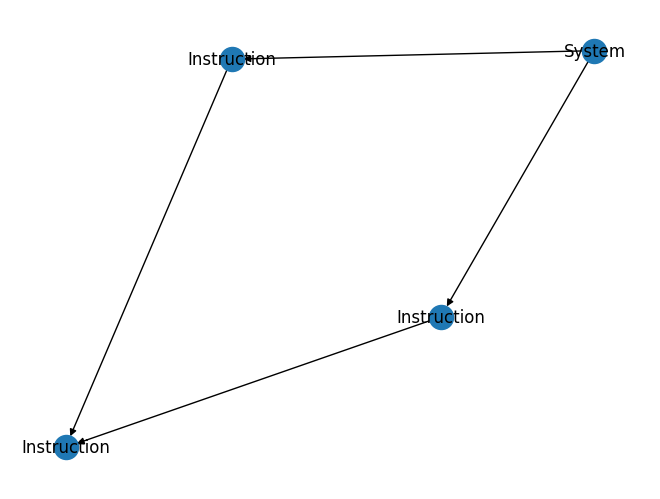

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

g = struct_multi.to_networkx()
labels = nx.get_node_attributes(g, "class_name")
nx.draw(g, labels=labels)

In [5]:
## output_parser parameter: agent self
## output_parser return: the expected result that should be returned after execution
def output_parser(agent):
    ## return all message dataframe in all branches
    output = []
    for branch in agent.executable.branches.values():
        output.append(branch.messages)
    return output

executable = InstructionMapExecutor()

In [6]:
calculator = BaseAgent(structure=struct_multi, executable=executable, output_parser=output_parser)

In [7]:
result = await calculator.execute(context={"x": 2, "y": 3})

------------------Welcome: system--------------------


system: You are asked to perform as a calculator. Return only a numeric value, i.e. int or float, no text.

user: {"sum the absolute values": "provided with 2 numbers, return the sum of their absolute values. i.e. |x|+|y|"}

user: {"diff the absolute values": "provided with 2 numbers, return the difference of absolute values. i.e. |x|-|y|"}

assistant: 5

-----------------------------------------------------


assistant: 1

-----------------------------------------------------


user: {"if previous response is positive": "times 2. i.e. *2", "else": "plus 2. i.e. +2"}

user: {"if previous response is positive": "times 2. i.e. *2", "else": "plus 2. i.e. +2"}

assistant: 2

-----------------------------------------------------


assistant: 10

-----------------------------------------------------


In [8]:
result[0]

,node_id,timestamp,role,sender,recipient,content
0,1c6296e1ad5a4a228415cc88613ae381,2024-04-22T02:07:27.750678+00:00,system,system,assistant,"{""system_info"": ""You are asked to perform as a..."
1,84429af397b0c50792a2c6122ff7f5b9,2024-04-22T02:07:27.751005+00:00,user,user,assistant,"{""instruction"": {""sum the absolute values"": ""p..."
2,7bec339c9a8745391e16fbac2da702b8,2024-04-22T02:07:29.929308+00:00,assistant,assistant,user,"{""response"": ""5""}"
3,78765b8d4f02b2d6bcb455166ba50e07,2024-04-22T02:07:27.751362+00:00,user,user,assistant,"{""instruction"": {""if previous response is posi..."
4,a2ecc4a6933d545ef94bd61cd77267cb,2024-04-22T02:07:30.938150+00:00,assistant,assistant,user,"{""response"": ""10""}"


In [9]:
result[1]

,node_id,timestamp,role,sender,recipient,content
0,1c6296e1ad5a4a228415cc88613ae381,2024-04-22T02:07:27.750678+00:00,system,system,assistant,"{""system_info"": ""You are asked to perform as a..."
1,371cc8b7eff6daaa40517cfc54912e39,2024-04-22T02:07:27.751098+00:00,user,user,assistant,"{""instruction"": {""diff the absolute values"": ""..."
2,5950bf473738c35a8501820e97225312,2024-04-22T02:07:29.966995+00:00,assistant,assistant,user,"{""response"": ""1""}"
3,78765b8d4f02b2d6bcb455166ba50e07,2024-04-22T02:07:27.751362+00:00,user,user,assistant,"{""instruction"": {""if previous response is posi..."
4,8d5b40cacb7c494766eda6b81fe43581,2024-04-22T02:07:30.776262+00:00,assistant,assistant,user,"{""response"": ""2""}"


# Storing Structures

We currently support the storage of structures in excel or Neo4j, enabling their reuse in future applications.

### Excel

In [ ]:
struct_multi.to_excel('math_multi')

### Neo4j

In [10]:
# initiate Neo4j Driver
uri = "bolt://localhost:7687"
user = "neo4j"
password = "12345678"
database = "neo4j"

from lionagi.integrations.storage.neo4j import Neo4j
neo4j = Neo4j(uri, user, password, database)

In [11]:
# structure_name is unique

await neo4j.store(struct_multi, structure_name='math_multi')